In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Necessary Libraries

In [4]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
BASE_DIR = '/kaggle/input'
WORKING_DIR = '/kaggle/working'

# Creating an instance of pretrained VGG16

In [5]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 3s 0us/step


# Feature Extraction 

In [44]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'flickr8k/Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features1.pkl'), 'wb'))

# Loading the features

In [6]:
# load features from pickle
with open(os.path.join('/kaggle/input/f1111111111/', 'features1.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
#loading the data's caption
with open(os.path.join(BASE_DIR, 'mytext/Flickr8k.token.txt'), 'r') as f:
    captions_doc = f.read()

**Dictionary 'mapping' is created with key as image_id and values as the corresponding caption text,Same image may have multiple captions.So,for each image total no. of datapoints created = no.of captions for that image**

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split('\t')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40461 [00:00<?, ?it/s]

# Train Test and validation split according to given by sir

In [9]:
with open(os.path.join(BASE_DIR, 'mytext/Flickr_8k.trainImages.txt'), 'r') as f:
    tr_captions_doc = f.read()
with open(os.path.join(BASE_DIR, 'mytext/Flickr_8k.testImages.txt'), 'r') as f:
    ts_captions_doc = f.read()
with open(os.path.join(BASE_DIR, 'mytext/Flickr_8k.valImages.txt'), 'r') as f:
    val_captions_doc = f.read()

In [10]:
train_id = []
train = tr_captions_doc.split('\n')
for i in train:
    image_id = i.split('.')[0]
    train_id.append(image_id)
    
test_id = []
test = ts_captions_doc.split('\n')
for i in test:
    image_id = i.split('.')[0]
    test_id.append(image_id)
    
val_id = []
val = val_captions_doc.split('\n')
for i in val:
    image_id = i.split('.')[0]
    val_id.append(image_id)

In [11]:
print(len(train_id))
print(len(test_id))
print(len(val_id))

6001
1001
1001


# Preprocess Text Data(each caption of an image)

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

**Finally we get three dictionaries train_mapping,test_mapping,val_mapping where in each dictionary each datapoint's key = image_id and value = caption**

In [13]:
train_mapping = {}
test_mapping = {}
val_mapping = {}

for i in train_id:
    if i!="":
        train_mapping[i] = mapping[i]
for i in test_id:
    if i!="":
        test_mapping[i] = mapping[i]
for i in val_id:
    if i!="":
        val_mapping[i] = mapping[i]
        

In [14]:
clean(train_mapping)
clean(test_mapping)
clean(val_mapping)

In [15]:
print(len(train_mapping))
print(len(test_mapping))
print(len(val_mapping))

6000
1000
1000


# Next we will store the preprocessed train captions into a list

In [16]:
#Next we will store the preprocessed training captions into a list
all_captions = []
for key in train_mapping:
    for caption in train_mapping[key]:
        all_captions.append(caption)
len(all_captions)

30000

# Now we tokenize the training data

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size #no. of unique words

7368

# Finding the maximum length of the captions, used for reference for the padding sequence.

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

**Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.**

In [18]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model(BASE LINE) Creation

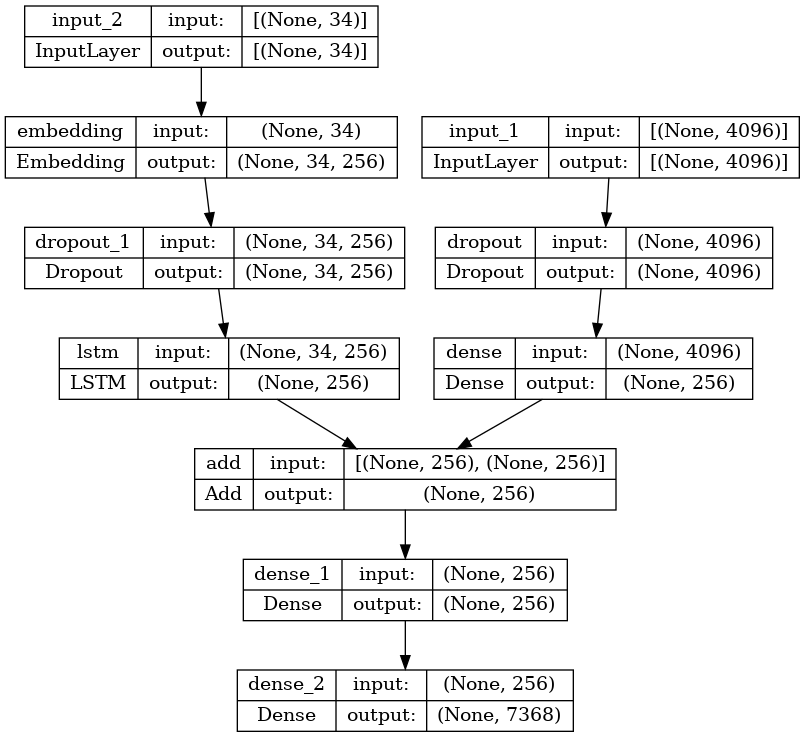

In [19]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)



# Training and Saving the Model

 **While trying validation and when training session is getting crashed **

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# train the model
epochs = 15
batch_size = 64
steps = len(train_mapping) // batch_size

#validation_data = data_generator(list(val_mapping.keys()), val_mapping, features, tokenizer, max_length, vocab_size, batch_size)

for i in range(epochs):
    if((i+1)%5==0):
        actual, predicted = list(), list()
        for key in tqdm(list(val_mapping.keys())[0:5]):
        # get actual caption
            captions = val_mapping[key]
        # predict the caption for image
            y_pred = predict_caption(model, features[key], tokenizer, max_length)
        # split into words
            actual_captions = [caption.split() for caption in captions]
            y_pred = y_pred.split()
        # append to the list
            actual.append(actual_captions)
            predicted.append(y_pred)
        # Compute BLEU score
        print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
        print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    
    # create data generator
    generator = data_generator(list(train_mapping.keys()), train_mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #validating on validation data
   
            
        

    


93/93 [==============================] - 48s 518ms/step - loss: 3.5480


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.561315
BLEU-2: 0.275099
 1/93 [..............................] - ETA: 1:18 - loss: 2.8041

In [21]:
from nltk.translate.bleu_score import corpus_bleu
# train the model
epochs = 15
batch_size = 64
steps = len(train_mapping) // batch_size

#validation_data = data_generator(list(val_mapping.keys()), val_mapping, features, tokenizer, max_length, vocab_size, batch_size)

for i in range(epochs):
#     if((i+1)%5==0):
#         actual, predicted = list(), list()
#         for key in tqdm(list(val_mapping.keys())[0:5]):
#         # get actual caption
#             captions = val_mapping[key]
#         # predict the caption for image
#             y_pred = predict_caption(model, features[key], tokenizer, max_length)
#         # split into words
#             actual_captions = [caption.split() for caption in captions]
#             y_pred = y_pred.split()
#         # append to the list
#             actual.append(actual_captions)
#             predicted.append(y_pred)
#         # Compute BLEU score
#         print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#         print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    
    # create data generator
    generator = data_generator(list(train_mapping.keys()), train_mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

93/93 [==============================] - 46s 491ms/step - loss: 2.4351


In [22]:
# save the model
model.save('/kaggle/working/'+'/model.h5')

# Generate Captions for the Image

In [24]:
#Convert the predicted index from the model into a word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [25]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

# TESTING ON UNSEEN TEST DATA

In [26]:
#Now we validate the test data using BLEU Score

from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_mapping.keys()):
    # get actual caption
    captions = test_mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    
    # calcuate test corpus BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.572391
BLEU-2: 0.344624


# Visualize the Results

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/kaggle/input/flickr8k', "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Ground Truth---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Ground Truth---------------------
startseq child puts dirt into his mouth endseq
startseq little boy who is playing outdoors is tasting dirt endseq
startseq small child squats and puts dirt into his mouth endseq
startseq toddler eats dirt endseq
startseq the little boy wearing the blue shirt is putting dirt in his mouth endseq
--------------------Predicted--------------------
startseq man in red shirt and jeans is sitting on the street endseq


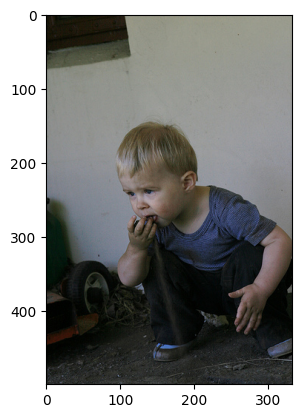

In [28]:
generate_caption("2647049174_0fb47cee2e.jpg")

---------------------Ground Truth---------------------
startseq basketball player performing lay-up endseq
startseq boy in blue basketball uniform number 13 and boy in white basketball uniform number 23 jump for the ball endseq
startseq man in white uniform jumps while holding basketball as another in blue blocks him endseq
startseq basketball player wearing white number 23 jersey jumps up with the ball while guarded by number 13 on the opposite team endseq
startseq the man in white is playing basketball against the man in blue endseq
--------------------Predicted--------------------
startseq the basketball player in the white shirt is dribbling the ball endseq


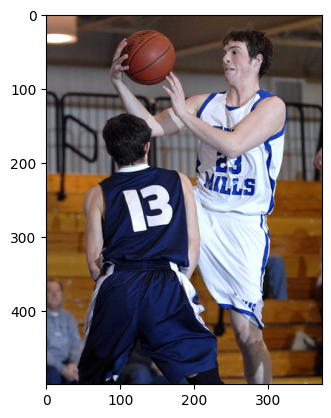

In [31]:
generate_caption("3259666643_ae49524c81.jpg")

---------------------Ground Truth---------------------
startseq man dressed in black wearing hat and glasses in front of red wall endseq
startseq man in black hat stands in front of red wall endseq
startseq man wearing all black and black hat is smiling endseq
startseq man with hat glasses jewelry and jacket stands against an orange wall endseq
startseq there is man with glasses and hat wearing black suit jacket indoors endseq
--------------------Predicted--------------------
startseq man in black jacket and black jacket is standing in front of building endseq


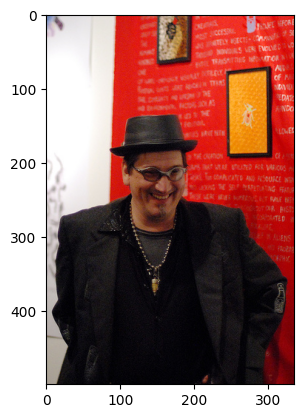

In [32]:
generate_caption("2167644298_100ca79f54.jpg")

---------------------Ground Truth---------------------
startseq boy eats with spoon endseq
startseq little boy holds spoon up to his mouth endseq
startseq little boy is eating his food off of spoon while sitting on patio endseq
startseq small child dressed in green is eating with spoon endseq
startseq young child holds spoon to its mouth while sitting in chair endseq
--------------------Predicted--------------------
startseq little boy with blue shirt and blue shirt is holding gun endseq


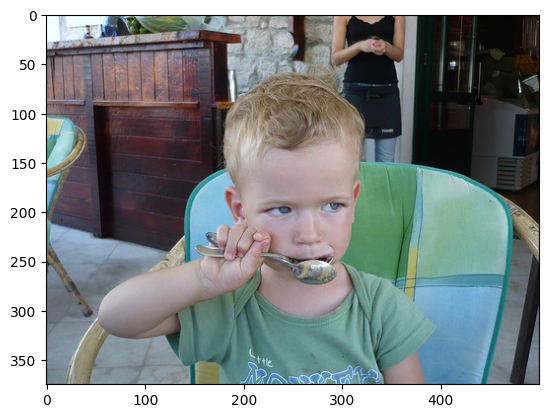

In [33]:
generate_caption("1224851143_33bcdd299c.jpg")

---------------------Ground Truth---------------------
startseq brown dog about to jump on smaller black and tan dog endseq
startseq large dog playing with smaller dog endseq
startseq two dogs are playing together outside endseq
startseq two dogs playing in the grass with an adult nearby endseq
startseq two dogs playing with each other endseq
--------------------Predicted--------------------
startseq two dogs play in field endseq


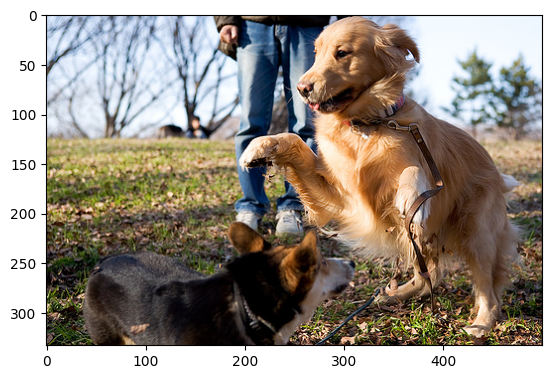

In [34]:
generate_caption("387830531_e89c192b92.jpg")

---------------------Ground Truth---------------------
startseq dog with blue ball running in field endseq
startseq small tan dog running on the grass with ball in his mouth endseq
startseq dog running towards camera with ball in its mouth endseq
startseq small dog running in the grass with toy in its mouth endseq
startseq the dog is running with colorful ball endseq
--------------------Predicted--------------------
startseq dog chases ball in field endseq


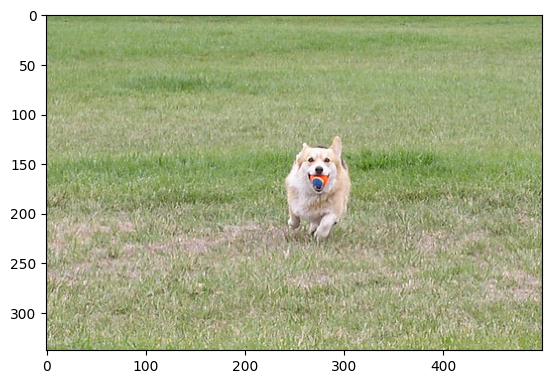

In [35]:
generate_caption("270724499_107481c88f.jpg")

# Model(Modified BASE LINE) Creation for updating vision embedding

58889256/58889256 [==============================] - 0s 0us/step


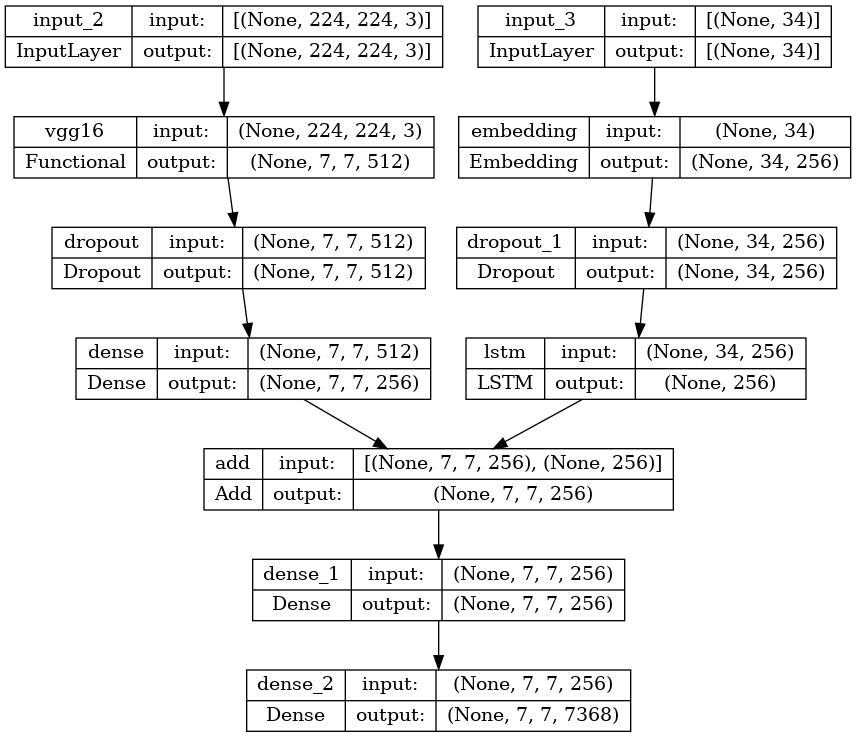

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


# Define the VGG16 model with pre-trained weights
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = False  # Freeze all layers

# Encoder model
inputs1 = Input(shape=(224, 224, 3))
fe1 = vgg16(inputs1)
fe2 = Dropout(0.4)(fe1)
fe3 = Dense(256, activation='relu')(fe2)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe3, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Set the trainable layers
for layer in model.layers:
    if layer.name == 'dense':  # Unfreeze the last linear layer
        layer.trainable = True
    else:
        layer.trainable = False

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam())

# Plot the model architecture
plot_model(model, show_shapes=True)


In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping,tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    image = Image.open('/kaggle/input/flickr8k/Images/'+key+'.'+'jpg')

                    # Resize the image to (224, 224)
                    image = image.resize((224, 224))

                    # Convert the image to a NumPy array
                    image_array = np.array(image)

                    # Reshape the array to (224, 224, 3)
                    reshaped_array = image_array.reshape((224, 224, 3))
                    X1.append(reshaped_array)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2 = np.array(X1), np.array(X2)
                y = np.array(y)
                y = np.reshape(y, (y.shape[0], 1, y.shape[1]))  # Reshape the target tensor
                y = np.tile(y, (1, 7, 7, 1))  # Repeat the target tensor to match output shape

                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [22]:
from PIL import Image
import numpy as np

In [23]:
l=list(train_mapping.keys())[0:500]

In [24]:
len(l)

500

In [25]:
d={}
for i in l:
    d[i]=train_mapping[i]

In [26]:
len(d)

500

In [28]:
 #generator = data_generator(list(train_mapping.keys())[0:2000], train_mapping, features, tokenizer, max_length, vocab_size, 4)

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# train the model
epochs = 1
batch_size = 4
steps = len(train_mapping) // batch_size

#validation_data = data_generator(list(val_mapping.keys()), val_mapping,tokenizer, max_length, vocab_size, batch_size)

for i in range(epochs):
    # create data generator
    generator = data_generator(l, d,tokenizer, max_length, vocab_size, batch_size)
    
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1500/1500 [==============================] - 3239s 2s/step - loss: 8.4413


In [29]:
# save the model
model.save('/kaggle/working/'+'/modified_baseline.h5')

In [35]:
#Convert the predicted index from the model into a word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Testing

In [49]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [50]:
#Now we validate the test data using BLEU Score

from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_mapping.keys()):
    # get actual caption
    captions = test_mapping[key]
    # predict the caption for image
    image = Image.open('/kaggle/input/flickr8k/Images/'+key+'.'+'jpg')

#     # Resize the image to (224, 224)
    image = image.resize((224, 224))

#     # Convert the image to a NumPy array
    image_array = np.array(image)

#     # Reshape the array to (224, 224, 3)
    reshaped_array = image_array.reshape((224, 224, 3))
    
    y_pred = predict_caption(model, np.expand_dims(reshaped_array, axis=0), tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    
    # calcuate test corpus BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.001284
BLEU-2: 0.001284


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
